In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

## 필요한 모듈 불러오기

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
reviews= pd.read_csv('reviews.csv')

In [ ]:
reviews.shape

(3020, 6)

## **데이터 전처리**

In [ ]:
# 필요없는 컬럼 제거
reviews = reviews.drop(labels=['Unnamed: 0.1', 'Unnamed: 0', 'index'], axis=1)

In [ ]:
reviews

,hotel,score,review
0,아리랑힐 호텔 동대문,5,최근에 회사 연수로 급 서울권 호텔을 검색했어요 코로나 이전보다 가격이 많이 올랐더...
1,아리랑힐 호텔 동대문,5,뚜벅이들에게 중요한 교통편이 편해서 좋았습니다. 6번 출구에서 바로 찾을 수 있고 ...
2,아리랑힐 호텔 동대문,5,작년 초에 친구들과 가성비 좋은 호텔을 찾아보다가 아리랑힐 호텔을 투숙했는데 다른 ...
3,아리랑힐 호텔 동대문,5,잠깐 서울 방문할 일이 있어 이용하였던 호텔인데 프런트 직원분들도 너무 친절하시고 ...
4,아리랑힐 호텔 동대문,5,성신여대 역에서 가까워 교통이 정말 편리합니다. 룸 컨디션도 좋아 정말 좋게 푹 쉬...
...,...,...,...
3015,롯데 호텔 월드,1,룸이 1818호라고 안내하며 웃음을 참는 직원을 제가 어떻게 받아들여야 하나요? 웃...
3016,롯데 호텔 월드,1,룸이 방음이 안돼서 옆방 아이 이야기소리에 자다 깼어요 복도랑 방 냄새도 퀘퀘하고 ...
3017,롯데 호텔 월드,1,Ⅰ-1. 2017년 11월 26일 본인의 장인어른께서 잠실롯데호텔 사우나 실을 이용...
3018,롯데 호텔 월드,1,1. 몇 년 전 방문 했을 때도 우리 가족은 매우 불쾌했다. 담당자는 체크아웃을 하...


In [ ]:
reviews.dropna()

,hotel,score,review
0,아리랑힐 호텔 동대문,5,최근에 회사 연수로 급 서울권 호텔을 검색했어요 코로나 이전보다 가격이 많이 올랐더...
1,아리랑힐 호텔 동대문,5,뚜벅이들에게 중요한 교통편이 편해서 좋았습니다. 6번 출구에서 바로 찾을 수 있고 ...
2,아리랑힐 호텔 동대문,5,작년 초에 친구들과 가성비 좋은 호텔을 찾아보다가 아리랑힐 호텔을 투숙했는데 다른 ...
3,아리랑힐 호텔 동대문,5,잠깐 서울 방문할 일이 있어 이용하였던 호텔인데 프런트 직원분들도 너무 친절하시고 ...
4,아리랑힐 호텔 동대문,5,성신여대 역에서 가까워 교통이 정말 편리합니다. 룸 컨디션도 좋아 정말 좋게 푹 쉬...
...,...,...,...
3015,롯데 호텔 월드,1,룸이 1818호라고 안내하며 웃음을 참는 직원을 제가 어떻게 받아들여야 하나요? 웃...
3016,롯데 호텔 월드,1,룸이 방음이 안돼서 옆방 아이 이야기소리에 자다 깼어요 복도랑 방 냄새도 퀘퀘하고 ...
3017,롯데 호텔 월드,1,Ⅰ-1. 2017년 11월 26일 본인의 장인어른께서 잠실롯데호텔 사우나 실을 이용...
3018,롯데 호텔 월드,1,1. 몇 년 전 방문 했을 때도 우리 가족은 매우 불쾌했다. 담당자는 체크아웃을 하...


### 긍정/부정 라벨링

In [ ]:
def rating_to_label(score):
  if score > 3:
    return 1
  else:
    return 0

reviews['y'] = reviews['score'].apply(lambda x: rating_to_label(x))

In [ ]:
reviews

,hotel,score,review,y
0,아리랑힐 호텔 동대문,5,최근에 회사 연수로 급 서울권 호텔을 검색했어요 코로나 이전보다 가격이 많이 올랐더...,1
1,아리랑힐 호텔 동대문,5,뚜벅이들에게 중요한 교통편이 편해서 좋았습니다. 6번 출구에서 바로 찾을 수 있고 ...,1
2,아리랑힐 호텔 동대문,5,작년 초에 친구들과 가성비 좋은 호텔을 찾아보다가 아리랑힐 호텔을 투숙했는데 다른 ...,1
3,아리랑힐 호텔 동대문,5,잠깐 서울 방문할 일이 있어 이용하였던 호텔인데 프런트 직원분들도 너무 친절하시고 ...,1
4,아리랑힐 호텔 동대문,5,성신여대 역에서 가까워 교통이 정말 편리합니다. 룸 컨디션도 좋아 정말 좋게 푹 쉬...,1
...,...,...,...,...
3015,롯데 호텔 월드,1,룸이 1818호라고 안내하며 웃음을 참는 직원을 제가 어떻게 받아들여야 하나요? 웃...,0
3016,롯데 호텔 월드,1,룸이 방음이 안돼서 옆방 아이 이야기소리에 자다 깼어요 복도랑 방 냄새도 퀘퀘하고 ...,0
3017,롯데 호텔 월드,1,Ⅰ-1. 2017년 11월 26일 본인의 장인어른께서 잠실롯데호텔 사우나 실을 이용...,0
3018,롯데 호텔 월드,1,1. 몇 년 전 방문 했을 때도 우리 가족은 매우 불쾌했다. 담당자는 체크아웃을 하...,0


### 훈련/검증 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split

x = reviews
y = reviews['y']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [ ]:
print('training set size:', len(x_train))
print('testing set size:', len(x_test))

training set size: 2265
testing set size: 755


In [ ]:
x_train

,hotel,score,review,y
559,페어필드 바이 메리어트 서울호텔,3,화장실이 오픈되어 있는 것은 알고 가서 별로 충격적이지는 않았습니다. 그런데 창호를...,0
2068,콘래드 서울,3,['생긴 지 얼마 되지 않기 때문에 역시 깨끗하고 방도 넓은 편입니다. IFC와 연...,0
1687,나인트리 프리미어 호텔 명동2,5,"['서비스,청결,위치 모두 완벽했습니다 특히 방 무료 업그레이드도 시켜주시고, 전화...",1
737,글래드 강남 코엑스 센터,5,방도 너무 좋고 깨끗해서 가족이 함께 묵기에도 너무 좋아요~ 제롬 직원님도 너무 친...,1
2415,롯데호텔 서울 이그제큐티브 타워,5,낯선 곳에서 마음의 편함을 느끼기가 쉽지 않은데 이곳은 나에게 “쉼” 이란 선물 같...,1
...,...,...,...,...
2763,페어몬트 앰배서더 서울,5,"여의도쪽에서 바이어와 미팅때문에 페어몬트 호텔 방문했는데, 와 향기가 너무 좋더라구...",1
905,메이 플레이스 서울 동대문,5,객실과 화장실 모두 청결하고 룸과 화장실이 생각보다 큽니다:) 심지어 트리플배드로 ...,1
1096,해밀톤 호텔,3,위치는 이태원역 바로앞이라 이동이 좋다 하지만 너무 낡았고 침대가 너무 불편해서 다...,0
235,호스텔 토미,5,친구랑 4박5일 서울에 놀러왓는데 되게 좋아여!! 깔끔하고 잠도잘오고 직원분들이 잘...,1


In [ ]:
x_train.to_csv('train_set.csv', encoding='utf-8-sig')
x_test.to_csv('test_set.csv', encoding='utf-8-sig')

In [ ]:
train_set = pd.read_csv('train_set.csv')
test_set = pd.read_csv('test_set.csv')

In [ ]:
# 필요없는 컬럼 제거
train_set = train_set.drop(labels=['Unnamed: 0'], axis=1)
test_set = test_set.drop(labels=['Unnamed: 0'], axis=1)

In [ ]:
# 중복 샘플 제거
train_set.drop_duplicates(subset=['review'], inplace=True)
test_set.drop_duplicates(subset=['review'], inplace=True)

<Axes: title={'center': 'test_set'}>

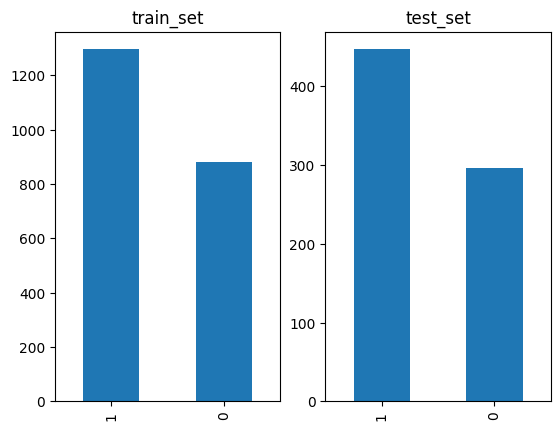

In [ ]:
# 긍정/부정 분포도 확인
plt.subplot(121)
plt.title('train_set')
train_set['y'].value_counts().plot(kind='bar')

plt.subplot(122)
plt.title('test_set')
test_set['y'].value_counts().plot(kind='bar')

In [ ]:
# 한글과 공백 제외하고 모두 제거
train_set['review'] = train_set['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_set[:5]

<ipython-input-71-2eac7ada82c3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_set['review'] = train_set['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,hotel,score,review,y
0,페어필드 바이 메리어트 서울호텔,3,화장실이 오픈되어 있는 것은 알고 가서 별로 충격적이지는 않았습니다 그런데 창호를 ...,0
1,콘래드 서울,3,생긴 지 얼마 되지 않기 때문에 역시 깨끗하고 방도 넓은 편입니다 와 연결되기 때문...,0
2,나인트리 프리미어 호텔 명동2,5,서비스청결위치 모두 완벽했습니다 특히 방 무료 업그레이드도 시켜주시고 전화로 미리 ...,1
3,글래드 강남 코엑스 센터,5,방도 너무 좋고 깨끗해서 가족이 함께 묵기에도 너무 좋아요 제롬 직원님도 너무 친절...,1
4,롯데호텔 서울 이그제큐티브 타워,5,낯선 곳에서 마음의 편함을 느끼기가 쉽지 않은데 이곳은 나에게 쉼 이란 선물 같았다...,1


In [ ]:
# 공백 제거 후 빈 값 있는지 확인
train_set['review'] = train_set['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_set['review'].replace('', np.nan, inplace=True)
print(train_set.isnull().sum())

test_set['review'] = test_set['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_set['review'] = test_set['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_set['review'].replace('', np.nan, inplace=True)
print(test_set.isnull().sum())

hotel     0
score     0
review    0
y         0
dtype: int64
hotel     0
score     0
review    0
y         0
dtype: int64


<ipython-input-140-877a1acac7b8>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_set['review'] = train_set['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
<ipython-input-140-877a1acac7b8>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  test_set['review'] = test_set['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-140-877a1acac7b8>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  test_set['review'] = test_set['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


### 토큰화

In [ ]:
# 불용어 제거

stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [ ]:
seoul_hotel_stopwords = ['서울','서울시','호텔','숙소','리뷰','직원','방문','조식','프론트','여행','재료','사진','예약','친구','엄마','어머니','출장','날씨','코로나','오후','한국','여자친구','남자친구','위치','객실','욕실','저녁','남성','여성','대략','남편','아내','침실','패키지']
for word in seoul_hotel_stopwords:
  stopwords.append(word)

In [ ]:
okt = Okt()
okt.morphs('서울에 있는 숙소인데도 불구하고 상태가 정말 별로입니다. 실망이네요', stem=True)

['서울',
 '에',
 '있다',
 '숙소',
 '인데',
 '도',
 '불구',
 '하고',
 '상태',
 '가',
 '정말',
 '별로',
 '이다',
 '.',
 '실망',
 '이네',
 '요']

In [ ]:
x_train = []
for sentence in tqdm(train_set['review']):
  tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
  tokenized_sentence = [word for word in tokenized_sentence if len(word)> 1] # 한글자 키워드 제거
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  x_train.append(stopwords_removed_sentence)

100%|██████████| 2175/2175 [00:40<00:00, 53.11it/s]


In [ ]:
x_test = []
for sentence in tqdm(test_set['review']):
  tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
  tokenized_sentence = [word for word in tokenized_sentence if len(word)> 1] # 한글자 키워드 제거
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
  x_test.append(stopwords_removed_sentence)

100%|██████████| 743/743 [00:13<00:00, 56.75it/s]


In [ ]:
print(x_train[:2])

[['화장실', '오픈', '되어다', '있다', '가다', '별로', '충격', '이지', '않다', '그런데', '창호', '저렴하다', '으로', '시공', '하다', '소음', '심하다', '창가', '앉다', '차갑다', '외풍', '그대로', '느껴지다', '그나마', '철길', '소음', '덜다', '차도', '시티', '뷰은', '차량', '소리', '시달리다', '아주', '작고', '아코르', '저가', '이비스', '보다도', '훨씬', '작다', '차라리', '샤워', '부스', '크기', '이고', '부분', '늘리다', '나다', '하다', '혼자', '하루', '자고', '가기', '괜찮다', '소음', '때문', '괜찮다', '지내다', '좁다', '답답하다', '그래도', '좋다', '인지', '중국인', '단체', '있다', '아침', '일찍', '체크아웃', '하다', '인데', '단체', '시간', '치다', '엘베', '타다', '힘들다'], ['생기다', '지다', '얼마', '되다', '않다', '때문', '역시', '깨끗하다', '방도', '넓다', '편입', '오다', '연결', '되다', '때문', '편리하다', '다만', '부페', '가격', '비다', '다소', '수준', '떨어지다', '여의도', '있다', '때문', '아니다', '이상', '추천', '하고', '싶다', '않다']]


### 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [ ]:
word_index = tokenizer.word_index

subset = list(word_index.items())[:5]

print(subset)

[('하다', 1), ('있다', 2), ('좋다', 3), ('이다', 4), ('에서', 5)]


In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 3보다 작은 단어의 등장 빈도수 총합

# 단어와 빈도수 쌍으로 get
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어 등장 빈도수 3보다 작으면
  if(value < threshold):
    rare_cnt += 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 7953
등장 빈도가 2번 이하인 희귀 단어의 수: 4579
단어 집합에서 희귀 단어의 비율: 57.57575757575758
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.133769777305513


In [ ]:
# 전체 단어 개수 중 빈도수 3미만인 단어 제거
# 0번 패딩 토큰 고려하여 +1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 3375


In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
print(x_train[:2])

[[69, 479, 25, 2, 13, 227, 1596, 945, 6, 744, 127, 10, 1, 232, 521, 1493, 365, 797, 2093, 446, 522, 1392, 232, 2393, 2774, 470, 875, 182, 29, 523, 1033, 2094, 1146, 372, 46, 1294, 139, 2394, 228, 141, 197, 2775, 172, 1, 327, 155, 660, 480, 89, 232, 42, 89, 198, 261, 767, 426, 3, 307, 1597, 1598, 2, 31, 308, 142, 1, 150, 1598, 28, 946, 1599, 496, 358], [637, 275, 798, 11, 6, 42, 316, 22, 309, 79, 947, 15, 296, 11, 42, 80, 344, 876, 33, 286, 661, 262, 217, 459, 2, 42, 48, 173, 59, 20, 38, 6]]


In [ ]:
print(x_test[:2])

[[40, 5, 669, 1, 360, 933, 248, 40, 161, 19, 2, 48, 590, 1056, 4, 509, 430, 54, 2, 28, 94, 2826, 3, 9, 14, 344, 328, 42, 2158, 514, 669, 198, 243, 4], [509, 71, 175, 165, 1, 4, 119, 360, 87, 1976, 908, 2672, 1209, 10, 872, 11, 76, 1162, 1, 2, 42, 4, 12, 132, 5, 388, 359, 1, 225, 274, 359, 18, 202, 298, 298, 263, 11, 1043, 298, 140, 12, 92, 66, 1152, 2827, 75, 1, 18, 791, 50, 12, 10, 1, 183, 1453, 921, 42, 166, 342, 1539, 1171, 104, 481, 10, 155, 873, 750, 119, 1, 894, 1, 103, 41, 1539, 1171, 166, 342, 346, 750, 2, 1115, 13, 2, 12, 739, 41, 928, 723, 3080, 10, 989, 11, 723, 34, 139, 69, 13, 2, 404, 32, 2, 1286, 1500, 2715, 21, 1454, 1133, 12, 66, 243, 231, 982, 658, 1283, 2591, 2, 12, 739, 322, 5, 377, 1850, 1298, 2449, 646, 827, 11, 204, 2706, 2, 1329, 90, 4, 308, 5, 182, 493, 3, 268, 41, 1482, 11, 2738, 2, 182, 173, 1177, 184, 12, 249, 1887, 182, 190, 2399, 182, 4, 382, 12, 542, 5, 120, 422, 2]]


In [ ]:
y_train = np.array(train_set['y'])
y_test = np.array(test_set['y'])

In [ ]:
# 빈 샘플 제거
drop_train = [index for index, sentence in enumerate(x_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(x_test) if len(sentence) < 1]

In [ ]:
x_train = np.delete(x_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

x_test = np.delete(x_test, drop_train, axis=0)
y_test = np.delete(y_test, drop_train, axis=0)

print(len(x_train))
print(len(y_train))

2175
2175


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


### 패딩

리뷰의 최대 길이 : 228
리뷰의 평균 길이 : 48.43586206896552


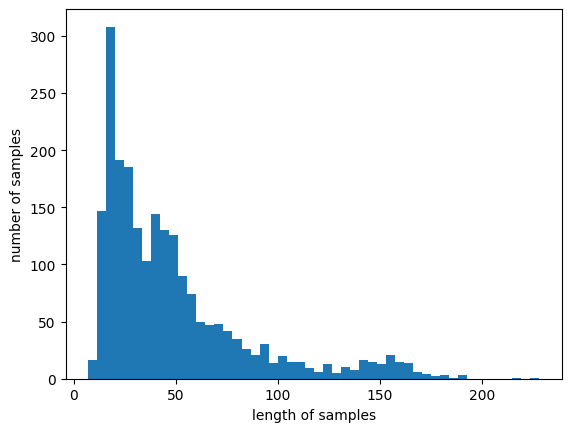

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in x_train))
print('리뷰의 평균 길이 :',sum(map(len, x_train))/len(x_train))

plt.hist([len(review) for review in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 150
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 150 이하인 샘플의 비율: 96.45977011494253


In [ ]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

## **LSTM**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
28/28 [==============================] - ETA: 0s - loss: 0.6540 - acc: 0.5994
Epoch 1: val_acc improved from -inf to 0.65057, saving model to best_model.h5
28/28 [==============================] - 11s 302ms/step - loss: 0.6540 - acc: 0.5994 - val_loss: 0.5732 - val_acc: 0.6506
Epoch 2/15
28/28 [==============================] - ETA: 0s - loss: 0.4645 - acc: 0.8034
Epoch 2: val_acc improved from 0.65057 to 0.79310, saving model to best_model.h5
28/28 [==============================] - 7s 268ms/step - loss: 0.4645 - acc: 0.8034 - val_loss: 0.4425 - val_acc: 0.7931
Epoch 3/15
28/28 [==============================] - ETA: 0s - loss: 0.3270 - acc: 0.8747
Epoch 3: val_acc improved from 0.79310 to 0.89195, saving model to best_model.h5
28/28 [==============================] - 6s 229ms/step - loss: 0.3270 - acc: 0.8747 - val_loss: 0.2908 - val_acc: 0.8920
Epoch 4/15
28/28 [==============================] - ETA: 0s - loss: 0.2294 - acc: 0.9144
Epoch 4: val_acc did not improve from 0.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

24/24 [==============================] - 2s 56ms/step - loss: 0.3008 - acc: 0.8627

 테스트 정확도: 0.8627


In [ ]:
# 토크나이저 파일로 저장 후 로드
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## **리뷰 예측**

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('너무 별로에요')

1/1 [==============================] - 0s 318ms/step
66.60% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('최고에요 다시 오고 싶어요')

1/1 [==============================] - 0s 27ms/step
83.03% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('서울호텔인데도 불구하고 별로네요. 서비스가 엉망이에요')

1/1 [==============================] - 0s 24ms/step
79.43% 확률로 부정 리뷰입니다.

